In [10]:
import s3fs
import boto3, botocore

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# local:
import s3_config

In [2]:
%%time
headers = [
    # Non-sentiment information about article
    'gkg_id', 'date', 'source', 'source_name', 'doc_id', 
    'themes', 'locations', 'persons', 'orgs', 
    # "Core emotional dimensions" & wc - see 1.5TONE in GKG codebook for details
    'tone',  # pos - neg
    'pos',  # % of words with "positive emotional connotation"
    'neg',  # % of words with "negative emotional connotation"
    'polarity',  # how emotionally charged is the text (as a %)
    'ard',  # activity reference density
    'srd',  # self/group reference density
    'wc',  # word count
    # Lexicoder sentiment dictionary
    'lexicode_neg', 'lexicode_pos',
    # Lexicoder Topic Dictionaries
    'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
    'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
    'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
    'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
    'INTL_AFFAIRS', 'GOVERNMENT_OPS',
    'LAND-WATER-MANAGEMENT', 'CULTURE',
    'PROV_LOCAL', 'INTERGOVERNMENTAL',
    'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
    'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
    'FORESTRY', 'LABOUR', 'IMMIGRATION',
    'EDUCATION', 'ENVIRONMENT',
    # Central Bank Financial Stability Sentiment
    'finstab_pos', 'finstab_neg', 'finstab_neutral',
    # Loughran & McDonald Financial Sentiment
    'finsent_neg', 'finsent_pos', 'finsent_unc',
    # Opinion observer
    'opin_neg', 'opin_pos',
    # SentiWord
    'sent_pos', 'sent_neg', 'sent_pol'
]

fs = s3fs.core.S3FileSystem(anon=False, profile=s3_config.normal_role)
with fs.open("s3://statsnz-covid-xmiles/merged_gdelt/gdelt-nz-20-21.csv") as f:
    nz = pd.read_csv(f)
nz.columns = headers
nz['date'] = pd.to_datetime(nz['date'], format = "%Y%m%d%H%M%S")

CPU times: user 49.6 s, sys: 5.55 s, total: 55.2 s
Wall time: 2min 26s


In [3]:
na_counts = {c: round(nz[c].isna().sum() / nz.shape[0], 4) for c in nz.columns}
na_counts

{'gkg_id': 0.0,
 'date': 0.0,
 'source': 0.0,
 'source_name': 0.0,
 'doc_id': 0.0,
 'themes': 0.1387,
 'locations': 0.0,
 'persons': 0.1271,
 'orgs': 0.1488,
 'tone': 0.0,
 'pos': 0.0,
 'neg': 0.0,
 'polarity': 0.0,
 'ard': 0.0,
 'srd': 0.0,
 'wc': 0.0,
 'lexicode_neg': 0.0062,
 'lexicode_pos': 0.0022,
 'MACROECONOMICS': 0.6698,
 'ENERGY': 0.9022,
 'FISHERIES': 0.9681,
 'TRANSPORTATION': 0.56,
 'CRIME': 0.7464,
 'SOCIAL_WELFARE': 0.9528,
 'HOUSING': 0.6112,
 'FINANCE': 0.5596,
 'DEFENCE': 0.8777,
 'SSTC': 0.7955,
 'FOREIGN_TRADE': 0.8973,
 'CIVIL_RIGHTS': 0.7289,
 'INTL_AFFAIRS': 0.658,
 'GOVERNMENT_OPS': 0.9052,
 'LAND-WATER-MANAGEMENT': 0.8318,
 'CULTURE': 0.0054,
 'PROV_LOCAL': 0.8488,
 'INTERGOVERNMENTAL': 0.9997,
 'CONSTITUTIONAL_NATL_UNITY': 0.9931,
 'ABORIGINAL': 0.9918,
 'RELIGION': 0.9113,
 'HEALTHCARE': 0.4635,
 'AGRICULTURE': 0.9355,
 'FORESTRY': 0.9462,
 'LABOUR': 0.7854,
 'IMMIGRATION': 0.8847,
 'EDUCATION': 0.8256,
 'ENVIRONMENT': 0.8524,
 'finstab_pos': 0.0042,
 'finstab

Need to convert lexicode (and other sentiments) to percentages, as they are currently counts.

In [53]:
count_headers = [
    # Lexicoder sentiment dictionary
    'lexicode_neg', 'lexicode_pos',
    # Lexicoder Topic Dictionaries
    'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
    'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
    'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
    'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
    'INTL_AFFAIRS', 'GOVERNMENT_OPS',
    'LAND-WATER-MANAGEMENT', 'CULTURE',
    'PROV_LOCAL', 'INTERGOVERNMENTAL',
    'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
    'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
    'FORESTRY', 'LABOUR', 'IMMIGRATION',
    'EDUCATION', 'ENVIRONMENT',
    # Central Bank Financial Stability Sentiment
    'finstab_pos', 'finstab_neg', 'finstab_neutral',
    # Loughran & McDonald Financial Sentiment
    'finsent_neg', 'finsent_pos', 'finsent_unc',
    # Opinion observer
    'opin_neg', 'opin_pos',
]

pos_headers = [h for h in headers if 'pos' in h]
print("Positive metrics:", pos_headers)
cols_to_summarise = ['date'] + pos_headers

nz_pct = nz.copy()
for col in count_headers:
    nz_pct[col] = nz_pct[col] / nz_pct['wc']

nz_pct_pos = nz_pct[cols_to_summarise].groupby('date').agg(['mean', np.std])
nz_pct_pos_long = nz_pct_summ.reset_index().melt(id_vars='date', var_name=['indicator','summary_metric'])
print("Head of summary df:")
nz_pct_pos.head(10)

Positive metrics: ['pos', 'lexicode_pos', 'finstab_pos', 'finsent_pos', 'opin_pos', 'sent_pos']
Head of summary df:


pos           lexicode_pos           finstab_pos  \
                         mean       std         mean       std        mean   
date                                                                         
2020-01-01 00:00:00  2.885212  1.204608     0.054620  0.032303    0.041448   
2020-01-01 00:15:00  3.172411  0.925562     0.049267  0.016983    0.037393   
2020-01-01 00:30:00  2.604686  0.989962     0.051338  0.021153    0.040166   
2020-01-01 00:45:00  3.014484  1.194287     0.050148  0.024208    0.039534   
2020-01-01 01:00:00  2.743349  1.005236     0.044934  0.011926    0.039228   
2020-01-01 01:15:00  2.871907  0.983061     0.048983  0.011489    0.035447   
2020-01-01 01:30:00  2.799644  1.062238     0.049431  0.013077    0.044812   
2020-01-01 01:45:00  2.347784  1.204377     0.045169  0.018294    0.043875   
2020-01-01 02:00:00  2.857023  1.308119     0.047242  0.016270    0.042126   
2020-01-01 02:15:00  2.288214  1.018100     0.046157  0.012867    0.037657   

                              finsent_pos            opin_pos            \
                          std        mean       std      mean       std   
date                                                                      
2020-01-01 00:00:00  0.021275    0.023195  0.023629  0.052738  0.028875   
2020-01-01 00:15:00  0.015854    0.011183  0.007891  0.047075  0.016249   
2020-01-01 00:30:00  0.019293    0.011140  0.006620  0.046462  0.017913   
2020-01-01 00:45:00  0.018986    0.012287  0.007929  0.046040  0.019818   
2020-01-01 01:00:00  0.014488    0.008855  0.004239  0.041599  0.012234   
2020-01-01 01:15:00  0.013585    0.008370  0.003766  0.042384  0.012542   
2020-01-01 01:30:00  0.018555    0.009530  0.005574  0.042793  0.011852   
2020-01-01 01:45:00  0.021416    0.011813  0.011977  0.040267  0.015782   
2020-01-01 02:00:00  0.019317    0.012475  0.008991  0.045826  0.018627   
2020-01-01 02:15:00  0.014961    0.008949  0.006093  0.038906  0.012568   

                     sent_pos            
                         mean       std  
date                                     
2020-01-01 00:00:00  0.251664  0.020443  
2020-01-01 00:15:00  0.247478  0.023145  
2020-01-01 00:30:00  0.246238  0.019647  
2020-01-01 00:45:00  0.254860  0.023408  
2020-01-01 01:00:00  0.243773  0.014229  
2020-01-01 01:15:00  0.242546  0.016821  
2020-01-01 01:30:00  0.246547  0.017358  
2020-01-01 01:45:00  0.246333  0.024145  
2020-01-01 02:00:00  0.251199  0.023314  
2020-01-01 02:15:00  0.240026  0.022606

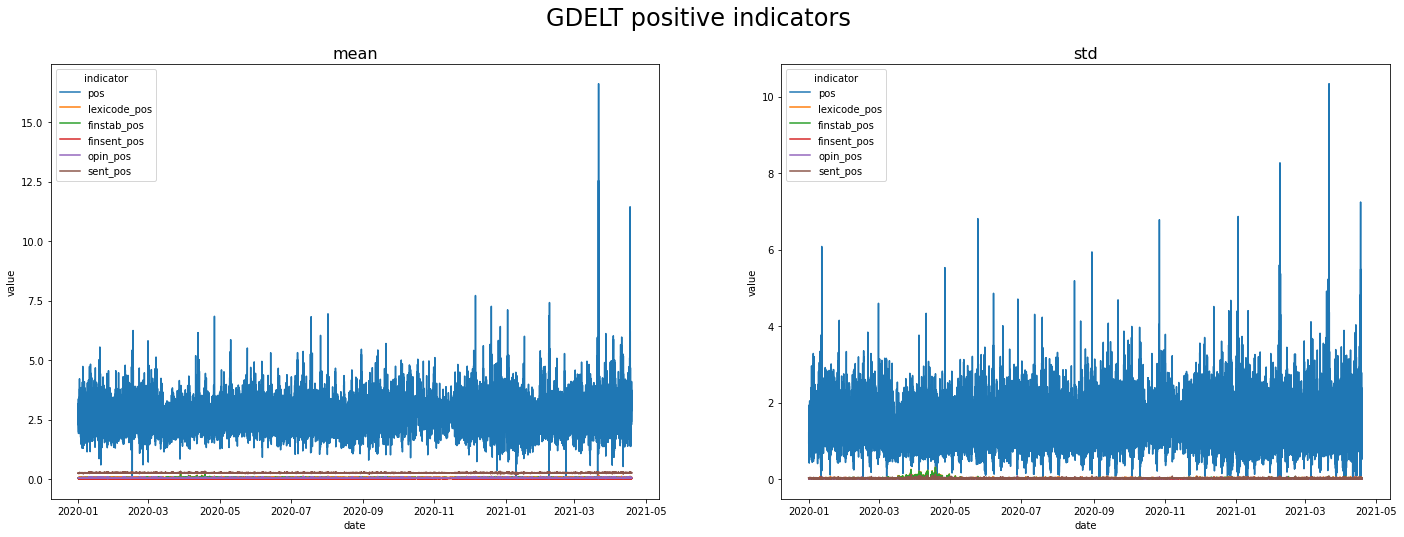

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("GDELT positive indicators", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_pos_long[nz_pct_summ_long['summary_metric'] == metric],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

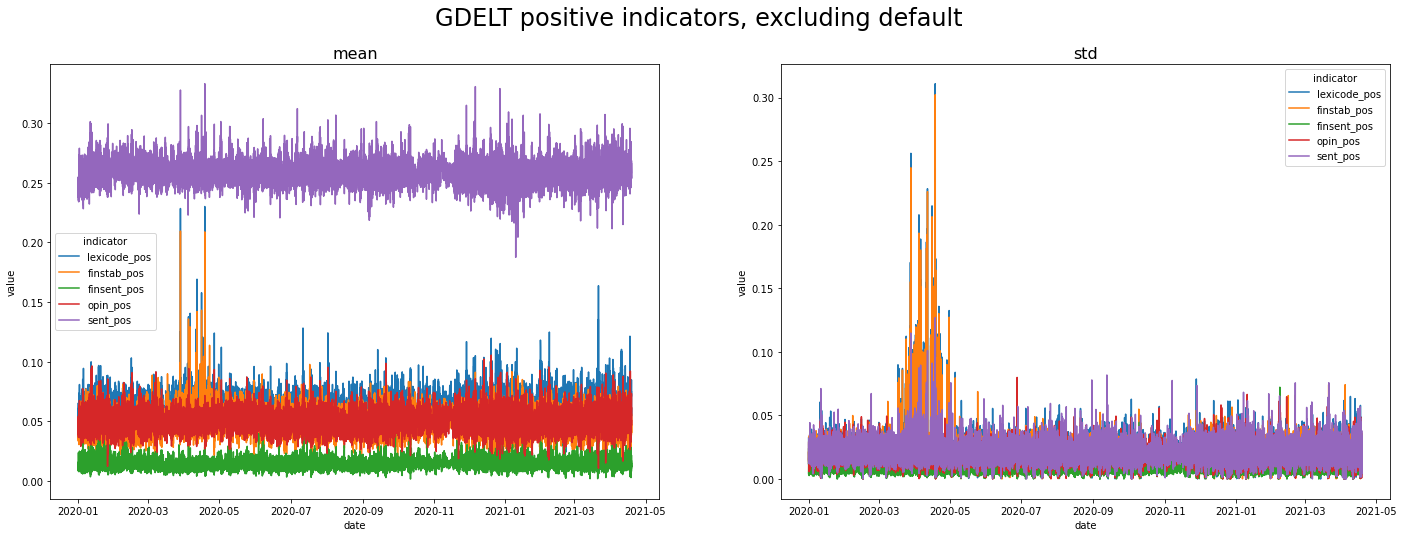

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("GDELT positive indicators, excluding default", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_pos_long[np.logical_and(nz_pct_summ_long['summary_metric'] == metric, nz_pct_summ_long['indicator'] != 'pos')],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

Even excluding the default positive, there is significant differences between the average of the other indicators. Their standard deviations do seem to be fairly consistent other than the start of COVID. Maybe a normalisation would show them behaving similarly then.

OR maybe it should be comparing the "tone" of each metric. Where the difference of the positive and negative is taken as the sentiment. **Will try this option first.**

In [139]:
# finstab can't be used as the finstab_neg column is all NAs
toneable_dicts = ['lexicode', 'finsent', 'opin']
nz_pct_tones = nz_pct[['date', 'tone']].rename(columns={'tone': 'default'})
for td in toneable_dicts:
    nz_pct_tones = pd.concat([
        nz_pct_tones,
        pd.Series(nz_pct[f"{td}_pos"] - nz_pct[f"{td}_neg"], name=td)
    ], axis = 1)
    
nz_pct_tones_summ = nz_pct_tones.groupby('date').agg(['mean', np.std])
nz_pct_tones_summ_long = nz_pct_tones_summ.reset_index().melt(id_vars='date', var_name=['indicator','summary_metric'])
nz_pct_tones_summ.head(10)

default            lexicode             finsent  \
                         mean       std      mean       std      mean   
date                                                                    
2020-01-01 00:00:00  0.103831  3.277929  0.016336  0.051726  0.004227   
2020-01-01 00:15:00 -0.098947  1.203188  0.005287  0.020811 -0.011805   
2020-01-01 00:30:00 -0.114375  1.578009  0.007753  0.025695 -0.012580   
2020-01-01 00:45:00 -0.333391  2.441089  0.006110  0.033675 -0.014877   
2020-01-01 01:00:00 -0.731098  1.256421  0.000596  0.017807 -0.014738   
2020-01-01 01:15:00 -1.046822  1.945088  0.000266  0.017366 -0.020862   
2020-01-01 01:30:00 -0.953118  2.112102  0.000204  0.019739 -0.020463   
2020-01-01 01:45:00 -0.990207  2.565735 -0.005685  0.027982 -0.018954   
2020-01-01 02:00:00 -0.414936  2.166284  0.000961  0.022075 -0.014012   
2020-01-01 02:15:00 -1.680532  2.250566 -0.006765  0.021263 -0.025051   

                                   opin            
                          std      mean       std  
date                                               
2020-01-01 00:00:00  0.032443  0.013192  0.043903  
2020-01-01 00:15:00  0.012420 -0.000532  0.030609  
2020-01-01 00:30:00  0.012692  0.001861  0.026777  
2020-01-01 00:45:00  0.017544 -0.000668  0.028027  
2020-01-01 01:00:00  0.009182 -0.007964  0.022170  
2020-01-01 01:15:00  0.014243 -0.006490  0.024421  
2020-01-01 01:30:00  0.016135 -0.009843  0.023573  
2020-01-01 01:45:00  0.024792 -0.016189  0.029959  
2020-01-01 02:00:00  0.016700 -0.004363  0.030260  
2020-01-01 02:15:00  0.019033 -0.015015  0.021884

In [141]:
nz_pct_tones_summ_long

,date,indicator,summary_metric,value
0,2020-01-01 00:00:00,default,mean,0.103831
1,2020-01-01 00:15:00,default,mean,-0.098947
2,2020-01-01 00:30:00,default,mean,-0.114375
3,2020-01-01 00:45:00,default,mean,-0.333391
4,2020-01-01 01:00:00,default,mean,-0.731098
...,...,...,...,...
343099,2021-04-18 22:15:00,opin,std,0.026648
343100,2021-04-18 22:30:00,opin,std,0.022540
343101,2021-04-18 22:45:00,opin,std,0.018465
343102,2021-04-18 23:00:00,opin,std,0.020861


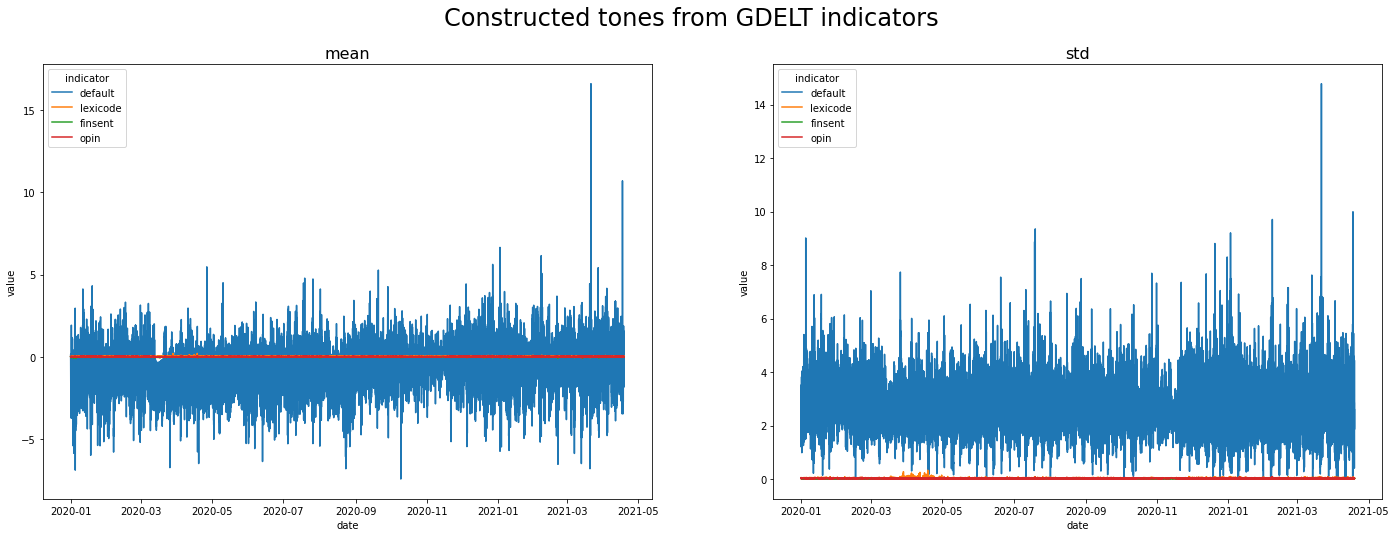

In [144]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("Constructed tones from GDELT indicators", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_tones_summ_long[nz_pct_tones_summ_long['summary_metric'] == metric],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

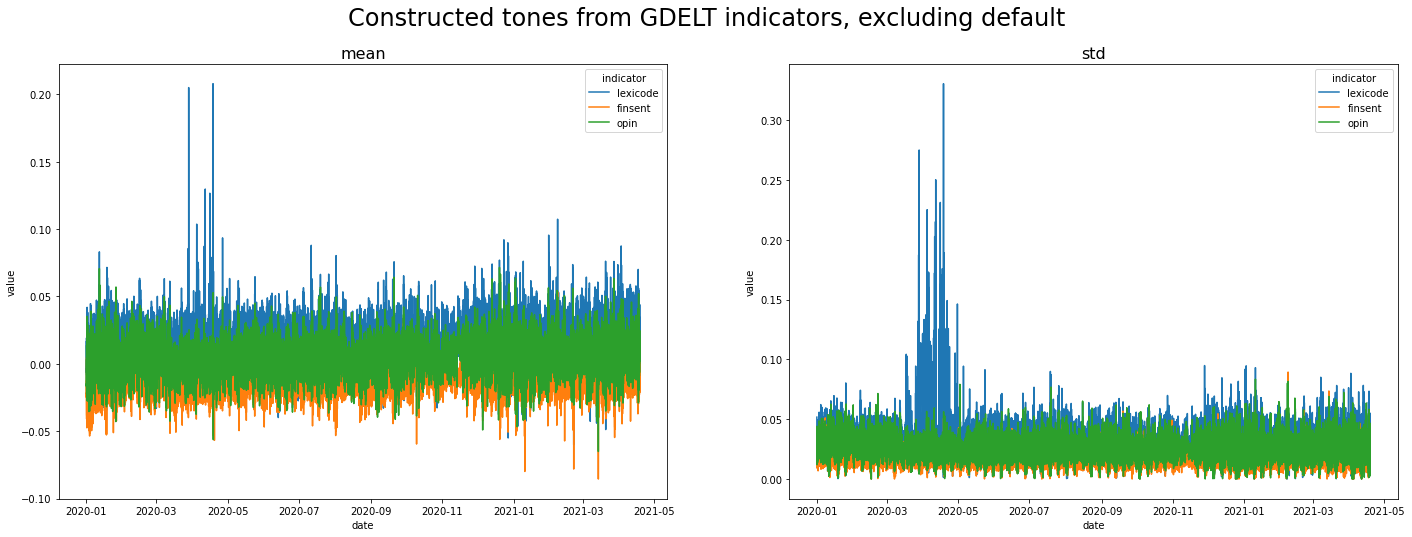

In [145]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("Constructed tones from GDELT indicators, excluding default", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_tones_summ_long[np.logical_and(nz_pct_tones_summ_long['summary_metric'] == metric, nz_pct_tones_summ_long['indicator'] != 'default')],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();